In [21]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import time
movies = pd.read_csv('movie_industry_clean.csv')

In [22]:
# data wrangling
def wrangling(df):
    df = df.drop('Unnamed: 0', axis=1)
    df.replace(' ', '_', regex=True, inplace = True)
    df.replace('-', '_', regex=True, inplace = True)
    df.dropna(inplace=True)
    return df

movies = wrangling(movies)

In [23]:
# grouping countries into continents
def continent(s):
    if s['country'] in ['United_States','Mexico', 'Canada','Jamaica']:
        return 'North_America'
    if s['country'] in ['United_Kingdom', 'France', 'Germany', 'Belgium','Spain', 'Norway', 'Iceland', 'West_Germany', 'Ireland', 'Italy', 'Finland', 'Czech_Republic', 'Switzerland', 'Sweden', 'Denmark', 'Netherlands','Federal_Republic_of_Yugoslavia','Yugoslavia', 'Hungary', 'Republic_of_Macedonia', 'Austria','Portugal','Malta']:
        return 'Europe'
    if s['country'] in ['Japan','China','South_Korea', 'Hong_Kong','India','United_Arab_Emirates','Taiwan','Lebanon','Indonesia', 'Iran','Israel','Russia','Thailand']:
        return 'Asia'
    if s['country'] in ['Australia','New_Zealand']:
        return 'Oceania'
    if s['country'] in ['South_Africa', 'Kenya']:
        return 'Africa'
    if s['country'] in ['Brazil', 'Argentina', 'Aruba', 'Chile', 'Panama','Colombia']:
        return 'South_America'
    else:
        return 'NA'

movies['continent'] = movies.apply(continent, axis=1)

In [24]:
# grouping years into decades
def decade(s):
    if s['year'].startswith('198'):
        return 'eighties'
    if s['year'].startswith('199'):
        return 'nineties'
    if s['year'].startswith('200'):
        return 'two_thousands'
    if s['year'].startswith('201'):
        return 'twenty_tens'
    if s['year'].startswith('202'):
        return 'twenty_twenties'
    else:
        return 'NA'

movies['year'] = movies['year'].astype(str)
movies['decade'] = movies.apply(decade, axis=1)
movies['year'] = pd.to_numeric(movies['year'])
movies['year'] = movies['year'].astype(int)

In [25]:
movies.dtypes

name          object
rating        object
genre         object
year           int64
released      object
score        float64
votes        float64
director      object
writer        object
star          object
country       object
budget       float64
gross        float64
company       object
runtime      float64
month         object
continent     object
decade        object
dtype: object

In [26]:
# grouping continents into "western" into continents
def western(s):
    if s['continent'] in ['North_America','Europe', 'Oceania','South_America']:
        return 1
    if s['continent'] in ['Asia', 'Africa']:
        return 0
    else:
        return 'NA'

movies['western'] = movies.apply(western, axis=1)

In [27]:
# split into training & test
np.random.seed(2)
train = movies.sample(round(movies.shape[0]*0.8)) # 80%
test = movies.drop(train.index)

# Resetting the indices for both test and train
train = train.reset_index()
train = train.drop(['index'], axis=1)
test = test.reset_index()
test = test.drop(['index'], axis=1)

In [29]:
test.rating.unique()

array(['R', 'PG', 'G', 'Not_Rated', 'PG_13', 'Unrated', 'X', 'NC_17',
       'TV_MA'], dtype=object)

<AxesSubplot:xlabel='decade', ylabel='gross'>

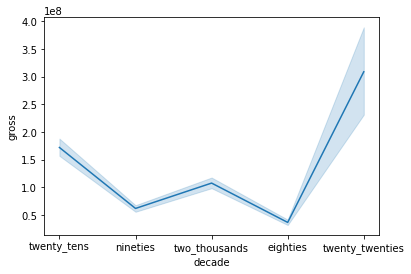

In [10]:
sns.lineplot(data = train, x = 'decade', y = 'gross')

## MODELING WITH NO INTERACTIONS/TRANSFORMATIONS

In [11]:
# the start of a model by hand - NO INTERACTIONS/TRANSFORMATIONS with only original variables (no 'decade')
ols_object = smf.ols(formula = 'gross~+budget+genre+rating+votes+continent+runtime+month+score+decade', data = train)
#ols_object = smf.ols(formula = 'gross~budget+votes+runtime+score+year+North_America+Europe+Asia+Oceania+South_America+Comedy+Action+Drama+Biography+Horror+Adventure+Crime+Animation+Fantasy+Thriller+Mystery+Sci_Fi+Family+Romance+PG_13+R+PG+Not_Rated+G+Unrated+X+NC_17+Approved', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     194.7
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:08:10   Log-Likelihood:                -86216.
No. Observations:                4332   AIC:                         1.725e+05
Df Residuals:                    4285   BIC:                         1.728e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -3.042e+07   1.19e+08     -0.256      0.798   -2.63e+08    2.02e+08
genre[T.Adventure]          1.153e+07   7.85e+06      1.469      0.142   -3.86e+06    2.69e+07
genre[T.Animation]          5.949e+07   1.03e+07      5.773      0.000    3.93e+07    7.97e+07
genre[T.Biography]          -2.11e+06   8.19e+06     -0.258      0.797   -1.82e+07     1.4e+07
genre[T.Comedy]             1.898e+07   4.85e+06      3.917      0.000    9.48e+06    2.85e+07
genre[T.Crime]              4.715e+06   7.26e+06      0.649      0.516   -9.53e+06     1.9e+07
genre[T.Drama]              6.996e+06   5.65e+06      1.237      0.216   -4.09e+06    1.81e+07
genre[T.Family]             3.342e+08    7.6e+07      4.394      0.000    1.85e+08    4.83e+08
genre[T.Fantasy]            1.575e+07   2.06e+07      0.764      0.445   -2.46e+07    5.62e+07
genre[T.Horror]             4.231e+07   8.57e+06      4.936      0.000    2.55e+07    5.91e+07
genre[T.Mystery]           -8.158e+06    2.8e+07     -0.291      0.771   -6.31e+07    4.68e+07
genre[T.Romance]            -1.89e+06   5.39e+07     -0.035      0.972   -1.08e+08    1.04e+08
genre[T.Sci_Fi]            -2.393e+07   4.39e+07     -0.545      0.586    -1.1e+08    6.22e+07
genre[T.Thriller]           4.343e+07   5.38e+07      0.807      0.419    -6.2e+07    1.49e+08
genre[T.Western]            1.853e+07   7.59e+07      0.244      0.807    -1.3e+08    1.67e+08
rating[T.G]                -4.775e+07   1.08e+08     -0.441      0.660    -2.6e+08    1.65e+08
rating[T.NC_17]            -4.682e+07   1.13e+08     -0.414      0.679   -2.68e+08    1.75e+08
rating[T.Not_Rated]        -3.098e+07   1.09e+08     -0.283      0.777   -2.45e+08    1.83e+08
rating[T.PG]               -3.288e+07   1.08e+08     -0.305      0.760   -2.44e+08    1.78e+08
rating[T.PG_13]            -3.676e+07   1.08e+08     -0.341      0.733   -2.48e+08    1.74e+08
rating[T.R]                 -5.31e+07   1.08e+08     -0.493      0.622   -2.64e+08    1.58e+08
rating[T.TV_MA]            -5.423e+07   1.52e+08     -0.357      0.721   -3.52e+08    2.44e+08
rating[T.Unrated]          -4.694e+07   1.12e+08     -0.420      0.675   -2.66e+08    1.72e+08
continent[T.Asia]           4.944e+07   4.94e+07      1.001      0.317   -4.74e+07    1.46e+08
continent[T.Europe]         3.079e+07   4.82e+07      0.639      0.523   -6.37e+07    1.25e+08
continent[T.North_America]  3.548e+07    4.8e+07      0.738      0.460   -5.87e+07     1.3e+08
continent[T.Oceania]        3.695e+07   5.04e+07      0.734      0.463   -6.18e+07    1.36e+08
continent[T.South_America]  5.039e+07   5.99e+07      0.842      0.400    -6.7e+07    1.68e+08
month[T.August]            -1.335e+07   7.91e+06     -1.688      0.092   -2.89e+07    2.16e+06
month[T.December]          -7.993e+06   8.2

In [12]:
#Plotting residuals vs fitted values
pred_gross = model.predict(test)
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_gross.min(),pred_gross.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'X' does not match any of the expected levels (expected: ['Approved', 'G', ..., 'TV_MA', 'Unrated'])
    gross~+budget+genre+rating+votes+continent+runtime+month+score+decade
                        ^^^^^^

In [13]:
# removing outliers/influential points

#Computing the leverage statistic for each observation
influence = model.get_influence()
leverage = influence.hat_matrix_diag

out = model.outlier_test()

#Average leverage of points
average_leverage = (model.df_model+1)/model.nobs
average_leverage

#We will remove all observations that have leverage higher than the threshold value.
high_leverage_threshold = 4*average_leverage

#Number of high leverage points in the dataset
print(np.sum(leverage>high_leverage_threshold))

#Dropping influential points from data
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0], (np.where(leverage>high_leverage_threshold)[0])))

train_filtered.shape

#Number of points removed as they were influential
print(train.shape[0]-train_filtered.shape[0])

/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


88
5


In [77]:
train_filtered

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,month,continent,decade,western
0,Remember_Me,PG_13,Drama,2010,"March_12,_2010_(United_States)",7.1,141000.0,Allen_Coulter,Will_Fetters,Robert_Pattinson,United_States,16000000.0,56032889.0,Summit_Entertainment,113.0,March,North_America,twenty_tens,1
1,Barney's_Great_Adventure,G,Adventure,1998,"April_3,_1998_(United_States)",3.2,3200.0,Steve_Gomer,Stephen_White,George_Hearn,Canada,15000000.0,12218638.0,Polygram_Filmed_Entertainment,76.0,April,North_America,nineties,1
2,The_Godfather:_Part_III,R,Crime,1990,"December_25,_1990_(United_States)",7.6,370000.0,Francis_Ford_Coppola,Mario_Puzo,Al_Pacino,United_States,54000000.0,136861392.0,Paramount_Pictures,162.0,December,North_America,nineties,1
3,A_Perfect_World,PG_13,Crime,1993,"November_24,_1993_(United_States)",7.5,76000.0,Clint_Eastwood,John_Lee_Hancock,Kevin_Costner,United_States,30000000.0,135130999.0,Warner_Bros.,138.0,November,North_America,nineties,1
4,Godzilla:_King_of_the_Monsters,PG_13,Action,2019,"May_31,_2019_(United_States)",6.0,162000.0,Michael_Dougherty,Michael_Dougherty,Kyle_Chandler,United_States,170000000.0,386600138.0,Warner_Bros.,132.0,May,North_America,twenty_tens,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,Gods_of_Egypt,PG_13,Action,2016,"February_26,_2016_(United_States)",5.4,110000.0,Alex_Proyas,Matt_Sazama,Brenton_Thwaites,United_States,140000000.0,150680864.0,Pyramania,127.0,February,North_America,twenty_tens,1
4328,Man_of_Steel,PG_13,Action,2013,"June_14,_2013_(United_States)",7.0,721000.0,Zack_Snyder,David_S._Goyer,Henry_Cavill,United_States,225000000.0,668045518.0,Warner_Bros.,143.0,June,North_America,twenty_tens,1
4329,Sense_and_Sensibility,PG,Drama,1995,"January_26,_1996_(United_States)",7.7,106000.0,Ang_Lee,Jane_Austen,Emma_Thompson,United_States,16000000.0,134582776.0,Columbia_Pictures,136.0,January,North_America,nineties,1
4330,Fright_Night,R,Comedy,2011,"August_19,_2011_(United_States)",6.4,101000.0,Craig_Gillespie,Marti_Noxon,Anton_Yelchin,United_States,30000000.0,41002607.0,Dreamworks_Pictures,106.0,August,North_America,twenty_tens,1


In [78]:
# SQUARE ROOT of the model
ols_object = smf.ols(formula = 'np.sqrt(gross)~month+budget*genre+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.sqrt(gross)   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     635.3
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        05:08:20   Log-Likelihood:                -41249.
No. Observations:                4332   AIC:                         8.254e+04
Df Residuals:                    4312   BIC:                         8.267e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.145e-06   4.21e-08     27.208      0.000    1.06e-06    1.23e-06
month[T.August]            1.986e-07   7.18e-09     27.666      0.000    1.85e-07    2.13e-07
month[T.December]         -1.559e-07   5.74e-09    -27.141      0.000   -1.67e-07   -1.45e-07
month[T.February]          9.158e-08   3.37e-09     27.208      0.000     8.5e-08    9.82e-08
month[T.January]           9.833e-08   3.61e-09     27.235      0.000    9.12e-08    1.05e-07
month[T.July]              2.113e-07   7.78e-09     27.179      0.000    1.96e-07    2.27e-07
month[T.June]              1.958e-07    7.2e-09     27.194      0.000    1.82e-07     2.1e-07
month[T.March]             9.562e-08   3.52e-09     27.201      0.000    8.87e-08    1.03e-07
month[T.May]               1.416e-07   5.21e-09     27.174      0.000    1.31e-07    1.52e-07
month[T.November]          3.447e-08   1.26e-09     27.289      0.000     3.2e-08    3.69e-08
month[T.October]           1.165e-07   4.28e-09     27.215      0.000    1.08e-07    1.25e-07
month[T.September]          7.04e-08   2.59e-09     27.213      0.000    6.53e-08    7.55e-08
genre[T.Adventure]         2.394e-08   8.79e-10     27.242      0.000    2.22e-08    2.57e-08
genre[T.Animation]        -5.665e-08   2.09e-09    -27.164      0.000   -6.07e-08   -5.26e-08
genre[T.Biography]         3.181e-08   1.17e-09     27.263      0.000    2.95e-08    3.41e-08
genre[T.Comedy]            3.637e-07   1.34e-08     27.202      0.000    3.37e-07     3.9e-07
genre[T.Crime]             6.258e-08    2.3e-09     27.218      0.000    5.81e-08    6.71e-08
genre[T.Drama]             1.787e-07   6.56e-09     27.234      0.000    1.66e-07    1.92e-07
genre[T.Family]            4.218e-11   1.38e-11      3.065      0.002    1.52e-11    6.92e-11
genre[T.Fantasy]           1.854e-08   6.82e-10     27.174      0.000    1.72e-08    1.99e-08
genre[T.Horror]            2.767e-07   1.02e-08     27.179      0.000    2.57e-07    2.97e-07
genre[T.Mystery]          -8.435e-09   3.11e-10    -27.133      0.000   -9.05e-09   -7.83e-09
genre[T.Romance]           -1.94e-09   7.13e-11    -27.194      0.000   -2.08e-09    -1.8e-09
genre[T.Sci_Fi]            1.427e-09   5.25e-11     27.158      0.000    1.32e-09    1.53e-09
genre[T.Thriller]          1.885e-09   6.92e-11     27.247      0.000    1.75e-09    2.02e-09
genre[T.Western]           2.583e-11   2.12e-11      1.219      0.223   -1.57e-11    6.73e-11
rating[T.G]               -6.372e-08   2.35e-09    -27.166      0.000   -6.83e-08   -5.91e-08
rating[T.NC_17]            1.258e-08   4.63e-10     27.193      0.000    1.17e-08    1.35e-08
rating[T.Not_Rated]         1.37e-08   5.04e-10     27.209      0.000    1.27e-08    1.47e-08
rating[T.PG]              -1.339e-07   4.93e-09    -27.152      0.000   -1.

## FORWARD VARIABLE SELECTION

In [14]:
def dummies_for_categorical_variables(df):
    rating_dummy = pd.get_dummies(df['rating'])
    df = pd.concat([df, rating_dummy], axis=1)
    df = df.drop('rating', axis=1)
    genre_dummy = pd.get_dummies(df['genre'])
    df = pd.concat([df, genre_dummy], axis=1)
    df = df.drop('genre', axis=1)
    continent_dummy = pd.get_dummies(df['continent'])
    df = pd.concat([df, continent_dummy], axis=1)
    df = df.drop('continent', axis=1)
    decade_dummy = pd.get_dummies(df['decade'])
    df = pd.concat([df, decade_dummy], axis=1)
    df = df.drop('decade', axis=1)
    month_dummy = pd.get_dummies(df['month'])
    df = pd.concat([df, month_dummy], axis=1)
    df = df.drop('month', axis=1)
    return df

train_variable_selection = dummies_for_categorical_variables(train_filtered)
test = dummies_for_categorical_variables(test)

In [80]:
train_filtered

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,month,continent,decade,western
0,Remember_Me,PG_13,Drama,2010,"March_12,_2010_(United_States)",7.1,141000.0,Allen_Coulter,Will_Fetters,Robert_Pattinson,United_States,16000000.0,56032889.0,Summit_Entertainment,113.0,March,North_America,twenty_tens,1
1,Barney's_Great_Adventure,G,Adventure,1998,"April_3,_1998_(United_States)",3.2,3200.0,Steve_Gomer,Stephen_White,George_Hearn,Canada,15000000.0,12218638.0,Polygram_Filmed_Entertainment,76.0,April,North_America,nineties,1
2,The_Godfather:_Part_III,R,Crime,1990,"December_25,_1990_(United_States)",7.6,370000.0,Francis_Ford_Coppola,Mario_Puzo,Al_Pacino,United_States,54000000.0,136861392.0,Paramount_Pictures,162.0,December,North_America,nineties,1
3,A_Perfect_World,PG_13,Crime,1993,"November_24,_1993_(United_States)",7.5,76000.0,Clint_Eastwood,John_Lee_Hancock,Kevin_Costner,United_States,30000000.0,135130999.0,Warner_Bros.,138.0,November,North_America,nineties,1
4,Godzilla:_King_of_the_Monsters,PG_13,Action,2019,"May_31,_2019_(United_States)",6.0,162000.0,Michael_Dougherty,Michael_Dougherty,Kyle_Chandler,United_States,170000000.0,386600138.0,Warner_Bros.,132.0,May,North_America,twenty_tens,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,Gods_of_Egypt,PG_13,Action,2016,"February_26,_2016_(United_States)",5.4,110000.0,Alex_Proyas,Matt_Sazama,Brenton_Thwaites,United_States,140000000.0,150680864.0,Pyramania,127.0,February,North_America,twenty_tens,1
4328,Man_of_Steel,PG_13,Action,2013,"June_14,_2013_(United_States)",7.0,721000.0,Zack_Snyder,David_S._Goyer,Henry_Cavill,United_States,225000000.0,668045518.0,Warner_Bros.,143.0,June,North_America,twenty_tens,1
4329,Sense_and_Sensibility,PG,Drama,1995,"January_26,_1996_(United_States)",7.7,106000.0,Ang_Lee,Jane_Austen,Emma_Thompson,United_States,16000000.0,134582776.0,Columbia_Pictures,136.0,January,North_America,nineties,1
4330,Fright_Night,R,Comedy,2011,"August_19,_2011_(United_States)",6.4,101000.0,Craig_Gillespie,Marti_Noxon,Anton_Yelchin,United_States,30000000.0,41002607.0,Dreamworks_Pictures,106.0,August,North_America,twenty_tens,1


In [93]:
#Creating a set of predictors from which we need to find the best subset of predictors - removing 1 dummy variable
X = train_variable_selection[['year','score','votes','budget','runtime','North_America', 'Europe', 'Asia', 'Oceania',
       'South_America','Comedy', 'Action', 'Drama', 'Biography', 'Horror', 'Adventure',
       'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi',
        'Romance','PG_13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'NC_17',
       'Approved','two_thousands','twenty_tens','twenty_twenties','eighties','June', 
       'July', 'May', 'December', 'October', 'September', 'February', 'April', 'August', 'March', 'November']]

In [95]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('gross~' + '+'.join(predictor_subset),data = train_variable_selection).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [96]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [97]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [98]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [99]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [100]:
models_best = forward_selection()

Processed  47 models on 1 predictors in 0.30358195304870605 seconds.
Processed  46 models on 2 predictors in 0.293198823928833 seconds.
Processed  45 models on 3 predictors in 0.5407149791717529 seconds.
Processed  44 models on 4 predictors in 0.45590972900390625 seconds.
Processed  43 models on 5 predictors in 0.4463810920715332 seconds.
Processed  42 models on 6 predictors in 0.48701000213623047 seconds.
Processed  41 models on 7 predictors in 0.4990999698638916 seconds.
Processed  40 models on 8 predictors in 0.5785248279571533 seconds.
Processed  39 models on 9 predictors in 0.7177610397338867 seconds.
Processed  38 models on 10 predictors in 0.5981659889221191 seconds.
Processed  37 models on 11 predictors in 0.6943149566650391 seconds.
Processed  36 models on 12 predictors in 0.6079320907592773 seconds.
Processed  35 models on 13 predictors in 0.6257309913635254 seconds.
Processed  34 models on 14 predictors in 0.6565549373626709 seconds.
Processed  33 models on 15 predictors in 

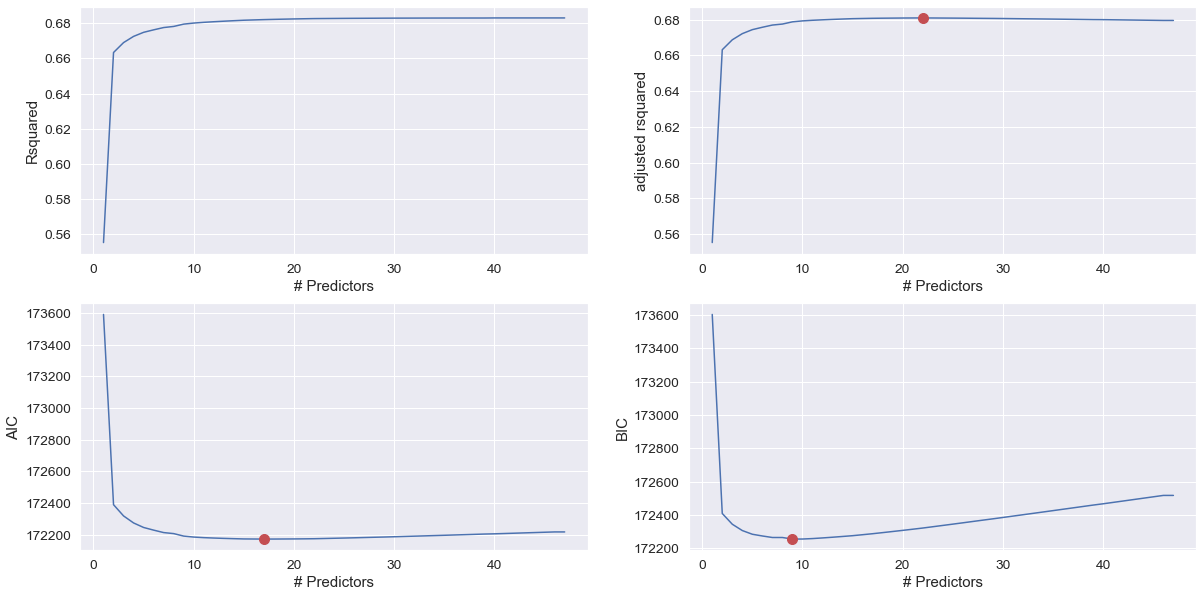

In [101]:
best_sub_plots()

In [102]:
best_fwd_reg_model1 = models_best['model'][9]
best_fwd_reg_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1017.
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        05:10:15   Log-Likelihood:                -86086.
No. Observations:                4327   AIC:                         1.722e+05
Df Residuals:                    4317   BIC:                         1.723e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.859e+07   4.42e+06     -8.731      0.000   -4.73e+07   -2.99e+07
budget            2.4927      0.048     51.848      0.000       2.398       2.587
votes           394.3316     10.148     38.858      0.000     374.436     414.227
Animation      6.437e+07   7.73e+06      8.327      0.000    4.92e+07    7.95e+07
two_thousands -1.244e+07   4.38e+06     -2.838      0.005    -2.1e+07   -3.85e+06
R             -1.784e+07   3.48e+06     -5.131      0.000   -2.47e+07    -1.1e+07
Horror         3.672e+07   7.86e+06      4.671      0.000    2.13e+07    5.21e+07
Comedy         1.651e+07   3.78e+06      4.373      0.000    9.11e+06    2.39e+07
twenty_tens    1.988e+07   4.52e+06      4.399      0.000     1.1e+07    2.87e+07
eighties        2.17e+07   5.15e+06      4.212      0.000    1.16e+07    3.18e+07
==============================================================================
Omnibus:                     4026.095   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           473365.290
Skew:                           4.044   Prob(JB):                         0.00
Kurtosis:                      53.598   Cond. No.                     2.75e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## BACKWARDS VARIABLE SELECTION

In [103]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [104]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [105]:
models_best = backward_selection()

Processed  47 models on 46 predictors in 3.2539358139038086 seconds.
Processed  46 models on 45 predictors in 2.552367687225342 seconds.
Processed  45 models on 44 predictors in 2.3550987243652344 seconds.
Processed  44 models on 43 predictors in 2.0957767963409424 seconds.
Processed  43 models on 42 predictors in 2.1765940189361572 seconds.
Processed  42 models on 41 predictors in 2.1654467582702637 seconds.
Processed  41 models on 40 predictors in 2.145570755004883 seconds.
Processed  40 models on 39 predictors in 2.9853830337524414 seconds.
Processed  39 models on 38 predictors in 2.3987748622894287 seconds.
Processed  38 models on 37 predictors in 2.743317127227783 seconds.
Processed  37 models on 36 predictors in 1.9957962036132812 seconds.
Processed  36 models on 35 predictors in 1.5079872608184814 seconds.
Processed  35 models on 34 predictors in 1.3477718830108643 seconds.
Processed  34 models on 33 predictors in 1.3433940410614014 seconds.
Processed  33 models on 32 predictors

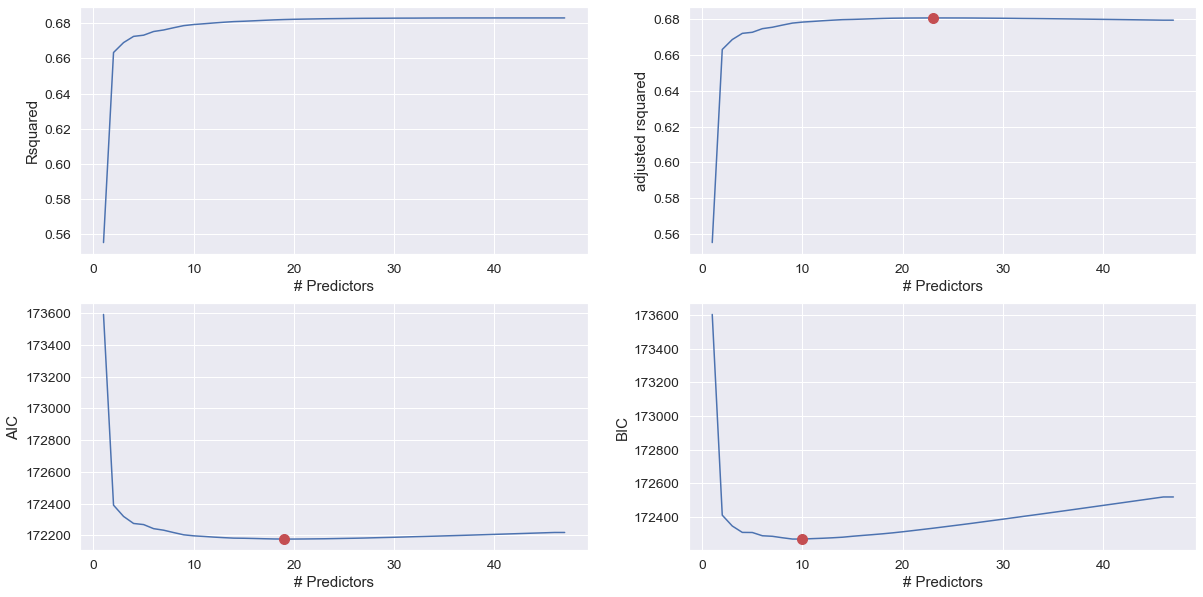

In [106]:
best_sub_plots()

In [107]:
best_bwd_reg_model1 = models_best['model'][10]
best_bwd_reg_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     913.8
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        05:11:18   Log-Likelihood:                -86088.
No. Observations:                4327   AIC:                         1.722e+05
Df Residuals:                    4316   BIC:                         1.723e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.221e+09   4.37e+08     -5.085      0.000   -3.08e+09   -1.36e+09
year           1.089e+06   2.18e+05      4.994      0.000    6.61e+05    1.52e+06
votes           392.1238     10.135     38.689      0.000     372.253     411.994
budget            2.4958      0.051     48.924      0.000       2.396       2.596
Action        -1.179e+07   4.04e+06     -2.920      0.004   -1.97e+07   -3.87e+06
Horror         2.846e+07   7.83e+06      3.636      0.000    1.31e+07    4.38e+07
Animation      5.878e+07    8.1e+06      7.260      0.000    4.29e+07    7.47e+07
PG_13          1.661e+07   3.85e+06      4.311      0.000    9.06e+06    2.42e+07
PG             2.177e+07    4.9e+06      4.442      0.000    1.22e+07    3.14e+07
two_thousands -2.178e+07   3.68e+06     -5.913      0.000    -2.9e+07   -1.46e+07
eighties       3.224e+07   6.22e+06      5.183      0.000       2e+07    4.44e+07
==============================================================================
Omnibus:                     4006.204   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           468870.712
Skew:                           4.011   Prob(JB):                         0.00
Kurtosis:                      53.361   Cond. No.                     1.49e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## MODELING WITH INTERACTIONS/TRANSFORMATIONS

In [108]:
# no transformations of the response variable
ols_object = smf.ols(formula = 'gross~month*budget*genre+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)', data = train_filtered)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     96.27
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        05:11:34   Log-Likelihood:                -85494.
No. Observations:                4327   AIC:                         1.713e+05
Df Residuals:                    4191   BIC:                         1.721e+05
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.0169      0.002     10.716      0.000       0.014       0.020
month[T.August]                                 -0.0188      0.002    -10.710      0.000      -0.022      -0.015
month[T.December]                                0.0005   4.22e-05     10.747      0.000       0.000       0.001
month[T.February]                                0.0010   9.02e-05     10.726      0.000       0.001       0.001
month[T.January]                                 0.0020      0.000     10.719      0.000       0.002       0.002
month[T.July]                                    0.0017      0.000     10.705      0.000       0.001       0.002
month[T.June]                                    0.0010   9.13e-05     10.728      0.000       0.001       0.001
month[T.March]                                   0.0011      0.000     10.716      0.000       0.001       0.001
month[T.May]                                     0.0009   8.33e-05     10.680      0.000       0.001       0.001
month[T.November]                                0.0008   7.68e-05     10.723      0.000       0.001       0.001
month[T.October]                                 0.0025      0.000     10.712      0.000       0.002       0.003
month[T.September]                               0.0013      0.000     10.714      0.000       0.001       0.002
genre[T.Adventure]                               0.0008   7.25e-05     10.715      0.000       0.001       0.001
genre[T.Animation]                              -0.0005   4.76e-05    -10.696      0.000      -0.001      -0.000
genre[T.Biography]                               0.0006   5.79e-05     10.718      0.000       0.001       0.001
genre[T.Comedy]                                  0.0050      0.000     10.712      0.000       0.004       0.006
genre[T.Crime]                                   0.0011   9.99e-05     10.715      0.000       0.001       0.001
genre[T.Drama]                                   0.0024      0.000     10.721      0.000       0.002       0.003
genre[T.Fantasy]                               1.59e-05   1.12e-05      1.417      0.157   -6.11e-06    3.79e-05
genre[T.Horror]                                  0.0034      0.000     10.707      0.000       0.003       0.004
genre[T.Mystery]                               2.49e-05   2.71e-06      9.205      0.000    1.96e-05    3.02e-05
genre[T.Romance]                              -1.32e-05   1.35e-06     -9.773      0.000   -1.59e-05   -1.06e-05
genre[T.Sci_Fi]                               8.943e-06    2.7e-06      3.315      0.001    3.65e-06    1.42e-05
genre[T.Thriller]                             6.823e-07   3.59e-06      0.190      0.849   -6.35e-06    7.72e-06
genre[T.Western]                

In [137]:
# RSE on training data
print(np.sqrt(model.mse_resid))
# RMSE
pred_gross = model.predict(test)
print(np.sqrt(((test.gross - pred_gross)**2).mean()))

107041604.88902853


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'X' does not match any of the expected levels (expected: ['Approved', 'G', ..., 'TV_MA', 'Unrated'])
    gross~+budget+genre+rating+votes+continent+runtime+month+score+decade
                        ^^^^^^

In [110]:
#Plotting residuals vs fitted values
pred_gross = model.predict(test)
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_gross.min(),pred_gross.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'month' is not defined
    gross~month*budget*genre+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)
          ^^^^^

In [118]:
# sqrt of the response variable
ols_object = smf.ols(formula = 'np.sqrt(gross)~month*budget*genre+score*votes+rating+decade*genre+I(budget**2)+I(votes**2)+np.sqrt(score*votes)', data = train)
model_sqrt = ols_object.fit()
model_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.sqrt(gross)   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     112.2
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        05:13:20   Log-Likelihood:                -40818.
No. Observations:                4332   AIC:                         8.191e+04
Df Residuals:                    4195   BIC:                         8.278e+04
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.0148      0.001     26.290      0.000       0.014       0.016
month[T.August]                                  0.0018   6.66e-05     26.297      0.000       0.002       0.002
month[T.December]                                0.0010   3.82e-05     26.289      0.000       0.001       0.001
month[T.February]                                0.0012   4.72e-05     26.290      0.000       0.001       0.001
month[T.January]                                 0.0012   4.48e-05     26.291      0.000       0.001       0.001
month[T.July]                                    0.0012   4.69e-05     26.291      0.000       0.001       0.001
month[T.June]                                    0.0012   4.44e-05     26.290      0.000       0.001       0.001
month[T.March]                                   0.0012   4.73e-05     26.290      0.000       0.001       0.001
month[T.May]                                     0.0011   4.28e-05     26.290      0.000       0.001       0.001
month[T.November]                                0.0012   4.61e-05     26.290      0.000       0.001       0.001
month[T.October]                                 0.0016   5.93e-05     26.291      0.000       0.001       0.002
month[T.September]                               0.0011   4.16e-05     26.291      0.000       0.001       0.001
genre[T.Adventure]                               0.0008   3.07e-05     26.290      0.000       0.001       0.001
genre[T.Animation]                               0.0003   1.11e-05     26.287      0.000       0.000       0.000
genre[T.Biography]                               0.0009   3.43e-05     26.290      0.000       0.001       0.001
genre[T.Comedy]                                  0.0047      0.000     26.290      0.000       0.004       0.005
genre[T.Crime]                                   0.0013   4.96e-05     26.290      0.000       0.001       0.001
genre[T.Drama]                                   0.0032      0.000     26.290      0.000       0.003       0.003
genre[T.Family]                               9.316e-11   1.23e-11      7.600      0.000    6.91e-11    1.17e-10
genre[T.Fantasy]                              4.395e-05   1.67e-06     26.290      0.000    4.07e-05    4.72e-05
genre[T.Horror]                                  0.0010   3.89e-05     26.293      0.000       0.001       0.001
genre[T.Mystery]                              1.935e-05   7.36e-07     26.289      0.000    1.79e-05    2.08e-05
genre[T.Romance]                              1.589e-06   6.05e-08     26.280      0.000    1.47e-06    1.71e-06
genre[T.Sci_Fi]                               6.969e-06   2.65e-07     26.291      0.000    6.45e-06    7.49e-06
genre[T.Thriller]               

Text(0, 0.5, 'Residuals')

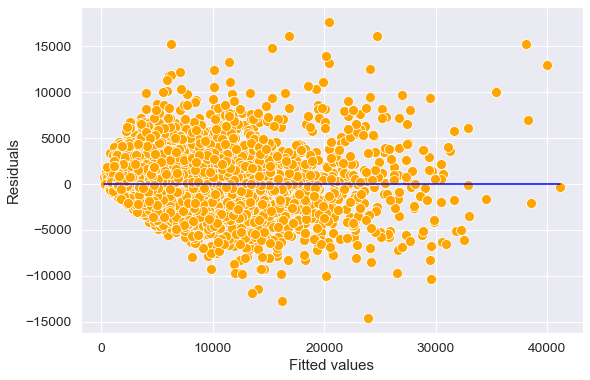

In [119]:
# sqrt model
sns.scatterplot(x = (model_sqrt.fittedvalues), y=(model_sqrt.resid),color = 'orange')
sns.lineplot(x = [model_sqrt.fittedvalues.min(),model_sqrt.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [120]:
# RSE on training data
print(np.sqrt(model_sqrt.mse_resid))
# RMSE
pred_sqrt_gross = model_sqrt.predict(test)
print(np.sqrt(((np.sqrt(test.gross) - (pred_sqrt_gross))**2).mean()))

3039.6758465451753


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'month' is not defined
    np.sqrt(gross)~month*budget*genre+score*votes+rating+decade*genre+I(budget**2)+I(votes**2)+np.sqrt(score*votes)
                   ^^^^^

In [121]:
# Confirming lack of missing values
model_sqrt.predict(test).isnull().sum()

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'month' is not defined
    np.sqrt(gross)~month*budget*genre+score*votes+rating+decade*genre+I(budget**2)+I(votes**2)+np.sqrt(score*votes)
                   ^^^^^

In [122]:
# Sorting model predictors by abs value of coefficient

params_sorted = abs(model_sqrt.params).sort_values(ascending=False)

params_df = pd.DataFrame(params_sorted, columns=['coefficient'])

params_df['p_value'] = model_sqrt.pvalues

params_df.loc[params_df['p_value'] <= 0.05].head(5)

,coefficient,p_value
np.sqrt(score * votes),6.324490,3.688939e-141
score,0.099678,3.861154e-141
votes,0.068825,4.283798e-61
Intercept,0.014776,3.810181e-141
rating[T.R],0.009780,3.831434e-141


In [126]:
# log of the model
ols_object = smf.ols(formula = 'np.log(gross)~month*budget*genre+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)', data = train)
model_log = ols_object.fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                     -18.020
Model:                            OLS   Adj. R-squared:                -18.641
Method:                 Least Squares   F-statistic:                    -29.00
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               1.00
Time:                        05:14:20   Log-Likelihood:                -15254.
No. Observations:                4332   AIC:                         3.078e+04
Df Residuals:                    4194   BIC:                         3.166e+04
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     1.714e-09   1.12e-10     15.287      0.000    1.49e-09    1.93e-09
month[T.August]                               5.625e-09   3.69e-10     15.261      0.000     4.9e-09    6.35e-09
month[T.December]                             2.563e-11   1.66e-12     15.401      0.000    2.24e-11    2.89e-11
month[T.February]                             8.905e-11   5.81e-12     15.331      0.000    7.77e-11       1e-10
month[T.January]                              2.183e-10   1.43e-11     15.280      0.000     1.9e-10    2.46e-10
month[T.July]                                 1.951e-10   1.27e-11     15.323      0.000     1.7e-10     2.2e-10
month[T.June]                                 8.466e-11   5.54e-12     15.278      0.000    7.38e-11    9.55e-11
month[T.March]                                 1.02e-10   6.69e-12     15.247      0.000    8.89e-11    1.15e-10
month[T.May]                                  7.023e-11   4.57e-12     15.382      0.000    6.13e-11    7.92e-11
month[T.November]                             7.798e-11    5.1e-12     15.292      0.000     6.8e-11     8.8e-11
month[T.October]                              2.749e-10    1.8e-11     15.269      0.000     2.4e-10     3.1e-10
month[T.September]                            1.418e-10   9.28e-12     15.271      0.000    1.24e-10     1.6e-10
genre[T.Adventure]                            7.872e-11   5.16e-12     15.250      0.000    6.86e-11    8.88e-11
genre[T.Animation]                           -5.724e-11   3.76e-12    -15.211      0.000   -6.46e-11   -4.99e-11
genre[T.Biography]                            5.703e-11   3.73e-12     15.276      0.000    4.97e-11    6.44e-11
genre[T.Comedy]                                5.22e-10   3.42e-11     15.249      0.000    4.55e-10    5.89e-10
genre[T.Crime]                                8.841e-11   5.79e-12     15.264      0.000    7.71e-11    9.98e-11
genre[T.Drama]                                2.473e-10   1.62e-11     15.273      0.000    2.16e-10    2.79e-10
genre[T.Family]                               2.687e-14   3.35e-14      0.802      0.423   -3.88e-14    9.25e-14
genre[T.Fantasy]                              3.981e-12   9.93e-13      4.009      0.000    2.03e-12    5.93e-12
genre[T.Horror]                               3.654e-10    2.4e-11     15.234      0.000    3.18e-10    4.12e-10
genre[T.Mystery]                             -4.781e-12   3.46e-13    -13.801      0.000   -5.46e-12    -4.1e-12
genre[T.Romance]                             -1.413e-12   1.09e-13    -12.945      0.000   -1.63e-12    -1.2e-12
genre[T.Sci_Fi]                               1.313e-12   2.36e-13      5.550      0.000    8.49e-13    1.78e-12
genre[T.Thriller]               

Text(0, 0.5, 'Residuals')

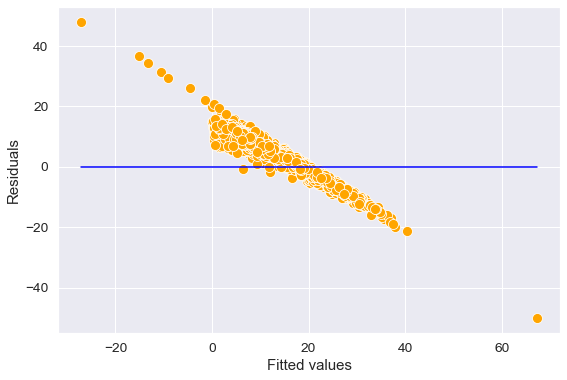

In [127]:
# log model
sns.scatterplot(x = (model_log.fittedvalues), y=(model_log.resid),color = 'orange')
sns.lineplot(x = [model_log.fittedvalues.min(),model_log.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [138]:
# RSE on training data
print(np.sqrt(model_log.mse_resid))
# RMSE
pred_log_gross = model_log.predict(test)
print(np.sqrt(((test.gross - np.exp(pred_log_gross))**2).mean()))

8.319309656740568


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'X' does not match any of the expected levels (expected: ['Approved', 'G', ..., 'TV_MA', 'Unrated'])
    np.log(gross)~month*budget*genre+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)
                                                 ^^^^^^

In [129]:
params_sorted = abs(model_sqrt.params).sort_values(ascending=False)

params_df = pd.DataFrame(params_sorted, columns=['coefficient'])

params_df['p_value'] = model_sqrt.pvalues

params_df.loc[params_df['p_value'] <= 0.05].head(5)

,coefficient,p_value
np.sqrt(score * votes),6.324490,3.688939e-141
score,0.099678,3.861154e-141
votes,0.068825,4.283798e-61
Intercept,0.014776,3.810181e-141
rating[T.R],0.009780,3.831434e-141
